In [1]:
import numpy as np
import pandas as pd

import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

### Notebook with OneHotencoder

In [2]:
data = pd.read_csv('data/hour.csv')
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
# Feature Enginnering

def categorize_temp(temp):
    if temp < 0.2:
        return 'cold'
    elif 0.2 <= temp < 0.4:
        return 'cool'
    elif 0.4 <= temp < 0.6:
        return 'moderate'
    elif 0.6 <= temp < 0.8:
        return 'warm'
    else:
        return 'hot'

def categorize_rush_hour(hr):
    if 7 <= hr <= 9 or 16 <= hr <= 19:
        return 'rush_hour'
    else:
        return 'non_rush_hour'
data['day_night'] = data['hr'].apply(lambda x: 'day' if 6 <= x <= 18 else 'night')
data['temp_range'] = data['temp'].apply(categorize_temp)
data['rush_hour'] = data['hr'].apply(categorize_rush_hour)

In [4]:
data.drop(['instant', 'casual', 'registered'], axis=1, inplace=True)
data['dteday'] = pd.to_datetime(data.dteday)
data['season'] = data.season.astype('category')
data['holiday'] = data.holiday.astype('category')
data['weekday'] = data.weekday.astype('category')
data['weathersit'] = data.weathersit.astype('category')
data['workingday'] = data.workingday.astype('category')
data['mnth'] = data.mnth.astype('category')
data['yr'] = data.yr.astype('category')
data['hr'] = data.hr.astype('category')
data.drop(columns=['dteday'], inplace=True)
#data.columns = data.columns.astype(str)
data.head(5)

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,day_night,temp_range,rush_hour
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16,night,cool,non_rush_hour
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40,night,cool,non_rush_hour
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32,night,cool,non_rush_hour
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13,night,cool,non_rush_hour
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1,night,cool,non_rush_hour


In [5]:
# Separating features and target variable
X = data.drop(columns=['cnt']) # Features
y = data['cnt'] # Target


In [6]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# Numerical features
numerical_features = ['temp', 'hum', 'windspeed']
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
    ('scaler', MinMaxScaler())  # Normalize using MinMaxScaler
])

# Transforming numerical features
X[numerical_features] = numerical_pipeline.fit_transform(X[numerical_features])

# Categorical features
categorical_features = ['season', 'weathersit', 'day_night', 'temp_range', 'rush_hour']
categorical_pipeline = Pipeline([
('imputer', SimpleImputer(strategy='most_frequent')),
('onehot', OneHotEncoder(sparse_output=False, drop='first'))
])
X_encoded = categorical_pipeline.fit_transform(X[categorical_features])
X_encoded = pd.DataFrame(X_encoded,
columns=categorical_pipeline.named_steps['onehot'].get_feature_names_out(categorical_features))
X = pd.concat([X.drop(columns=categorical_features), X_encoded], axis=1)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

<AxesSubplot:>

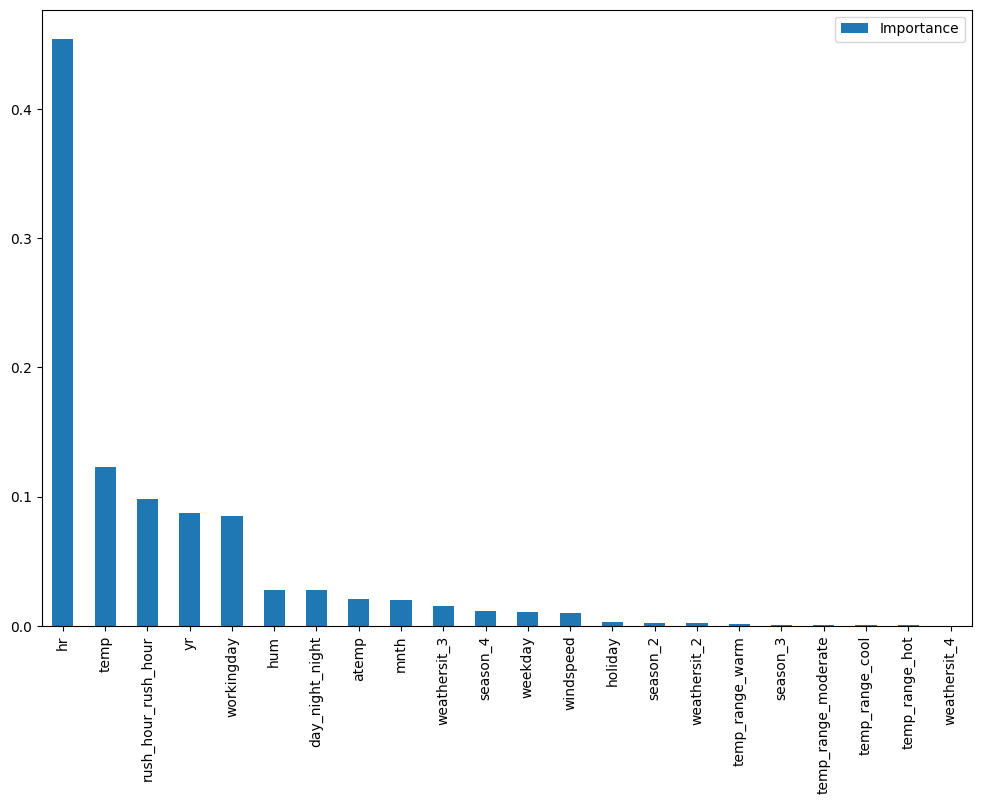

In [8]:
feat_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns,
columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
# Plotting each feature importance
feat_importances.plot(kind='bar', figsize=(12,8))

In [9]:

# Predict and evaluate with the test set
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")

RMSE: 42.46392115885513
R² Score: 0.943055071003943


In [10]:
from sklearn import set_config
final_pipeline = Pipeline([
('num_preprocess', numerical_pipeline),
('cat_preprocess', categorical_pipeline),
('model', RandomForestRegressor(n_estimators=100, random_state=42))
])
set_config(display='diagram')# To display
final_pipeline

Pipeline(steps=[('num_preprocess',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('scaler', MinMaxScaler())])),
                ('cat_preprocess',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='most_frequent')),
                                 ('onehot',
                                  OneHotEncoder(drop='first',
                                                sparse_output=False))])),
                ('model', RandomForestRegressor(random_state=42))])